# BT04: Softmax Regression

TODO: Võ Phương Hòa - 1412192

---

## Tổng thể

**Cách làm bài**

Bạn sẽ làm trực tiếp trên file notebook này; trong file, mình đã để từ `TODO` để cho biết những chỗ mà bạn cần phải làm (trong đó, `TODO` đầu tiên là bạn phải ghi họ tên và MSSV vào phần đầu của file). Trong khi làm bài, thường xuyên `Ctrl + S` để lưu lại bài làm của bạn, tránh mất mát thông tin.

Nên nhớ mục tiêu chính ở đây là *học, học một cách chân thật*. Bạn có thể thảo luận ý tưởng với bạn khác cũng như là tham khảo các tài liệu, nhưng *code và bài làm phải là của bạn, dựa trên sự hiểu của bạn*. Nếu vi phạm thì sẽ bị 0 điểm cho toàn bộ môn học.

**Cách nộp bài**

Trước khi nộp bài, bạn chọn `Kernel` -> `Restart & Run All` (restart python và chạy tất cả các cell), rồi kiểm tra xem có bị lỗi gì không.

Sau đó, trong thư mục `MSSV` (vd, nếu bạn có MSSV là 1234567 thì bạn đặt tên thư mục là `1234567`) bạn đặt file `BT04-SoftmaxRegression.ipynb` (không cần nộp file dữ liệu); rồi nén thư mục `MSSV` này lại và nộp ở link trên moodle.

**Nội dung bài tập**

Trong bài này, bạn sẽ huấn luyện mô hình Softmax Regression để dự đoán nhãn lớp của ảnh. Bộ dữ liệu được sử dụng là CIFAR-10. Đầu tiên, bạn đọc mô tả về bộ dữ liệu CIFAR-10 [ở đây](https://www.cs.toronto.edu/~kriz/cifar.html). Sau đó, bạn download file dữ liệu `CIFAR-10 python version`, giải nén ra được thư mục `cifar-10-batches-py`, và đặt thư mục này vào cùng thư mục chứa file notebook.

## Import

In [1]:
%matplotlib inline
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cPickle
# You can also import other things ...

## Định nghĩa các hàm

**Hàm đọc bộ dữ liệu CIFAR-10**

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict
def read_data(containing_dir, num_train_batchs):
    '''
    Read training and test data.
    
    Parameters
    ----------
    containing_dir : string
        The directory containing data files.
    num_train_batchs : int
        The number of data batchs used for training 
        (there are totally 5 data batchs; each one contains 10000 images).
    
    Returns
    -------
    (train_X, train_Y, test_X, test Y) : tuple
        train_X : numpy array, shape (num_train_batchs*10000, 32x32x3 + 1)
            The matrix of input vectors (each row corresponds to an input vector) of the training set;
            pixel values are normalized to [0, 1]; 
            the first column of this matrix is all ones (corresponding to x_0).
        train_Y : numpy array, shape (num_train_batchs*10000, 1)
            The vector of outputs of the training set.
        test_X : numpy array, shape (10000, 32x32x3 + 1)
            The matrix of input vectors of the test set (similar to train_X).
        test_Y : numpy array, shape (10000, 1)
            The vector of outputs of the test set.
    '''
    # Read training data
    train_X_batchs = []
    train_Y_batchs = []
    for batch_idx in range(num_train_batchs):
        batch = unpickle(containing_dir + '\\data_batch_' + str(batch_idx + 1))
        train_X_batchs.append(batch['data'])
        train_Y_batchs.append(np.array(batch['labels']).reshape(-1, 1))
    train_X = np.vstack(train_X_batchs)
    train_X = train_X / 255. # Normalize to [0, 1]
    train_X = np.hstack([np.ones((len(train_X), 1)), train_X])
    train_Y = np.vstack(train_Y_batchs)
    
    # Read test data
    batch = unpickle(containing_dir + '\\test_batch')
    test_X = batch['data']
    test_X = test_X / 255. # Normalize to [0, 1]
    test_X = np.hstack([np.ones((len(test_X), 1)), test_X])
    test_Y = np.array(batch['labels']).reshape(-1, 1)
    
    return (train_X, train_Y, test_X, test_Y)

#### Hàm cập nhật lại định dạng của train_Y

In [3]:
def update_train_Y(Y):
    '''
    Transfer format for train_Y.
    The old format of train_Y is a element is integer number.
    But with new format, each element of train_Y is a numpy array
    with all of values is zero, escape the value has index is the integer number of old train_Y.
    This value is one.
    '''
    new_Y = np.zeros(shape = (len(Y), len(np.unique(Y))))
    for y, new_y in zip(Y, new_Y):
        new_y[y[0]] = True
        
    return new_Y

**Hàm tính output của Softmax Regression**

In [4]:
def compute_softmax_output(W, X):
    '''
    Computes the outputs of Softmax Regression.
    
    Parameters
    ----------
    W : numpy array, shape (d+1, K=10)
        The matrix of Softmax Regression's parameters; each column corresponds to parameters of a class.
    X : numpy array, shape (N, d+1)
        The matrix of input vectors (each row corresponds to an input vector); the first column of 
        this matrix is all ones (corresponding to x_0).
    
    Returns
    -------
    A : numpy array, shape (N, K=10)
        The maxtrix of Softmax Regression's output vectors; each row is an output vector (containing each 
        class's probability given the corresponding input vector).
    '''
    # TODO
    # Initialize output A with all of values is 0
    A = np.zeros((len(X), W.shape[1]))
    
    # Output of Softmax Regression
    for i in range(len(X)):
        A[i] = np.exp(W.T.dot(X[i])) / sum(np.exp(W.T.dot(X[i])))
        
    return A

**Hàm huấn luyện Softmax Regression**

In [5]:
def train_softmax(X, Y, learning_rate, max_epoch):
    '''
    Trains Softmax Regression on the dataset (X, Y).
    Cost function: mean negative log likelihood.
    Optimization algorithm: Gradient Descent.
    
    Your code also needs to print out the cost and mean binary error on the training set after 
    each epoch (e.g., 'Epoch ..., cost ..., err ...%').
    
    Parameters
    ----------
    X : numpy array, shape (N, d + 1)
        The matrix of input vectors (each row corresponds to an input vector); the first column of 
        this matrix is all ones (corresponding to x_0).
    Y : numpy array, shape (N, 1)
        The vector of outputs.
    learning_rate : float
        Learning rate of Gradient Descent.
    max_epoch : int
        After this number of epochs (iterations), we'll terminate Gradient Descent.
    
    Returns
    -------
    (W, costs, errs) : tuple
        W : numpy array, shape (d+1, K=10)
            The maxtrix of Softmax Regression's parameters after training.
        costs : list, len = max_epoch
            The list of costs after each epoch.
        errs : list, len = max_epoch
            The list of mean binary errors (on the training set) after each epoch.
    '''
    # Init W
    K = len(np.unique(Y)) # Num classes
    W = np.zeros((X.shape[1], K))
    
    # TODO
    hypothesis = compute_softmax_output(W, X) # hypothesis with initialized W
    Y = update_train_Y(Y) # transfer correct output Y into a new format
    N = len(X)
    costs = []
    errs = []
    
    # training with gradient descent
    for e in range(max_epoch):
        # Find partial derivatives of E_in with hypothesis
        delta_W = X.T.dot(hypothesis - Y) / N
        # Update W
        W = np.array([w-learning_rate*delta_w for w, delta_w in zip(W, delta_W)])
        # Update hypothesis
        hypothesis = compute_softmax_output(W, X)
        # Find cost value with mean negative log likelihood
        cost = sum([-np.log(hy[int(np.argmax(y))]) for hy, y in zip(hypothesis, Y)]) / N
        # Find error
        err = sum([int(np.argmax(hy)) != int(np.argmax(y)) for y, hy in zip(hypothesis, Y)]) * 100.0 / N
        
        costs.append(cost)
        errs.append(err)
        
        print 'Epoch #%2d: cost = %.3f, err = %.3f%%' % (e, cost, err)
    
    return W, costs, errs

## Chạy

**1.** Đọc dữ liệu (bạn cần đặt thư mục chứa dữ liệu `cifar-10-batches-py` vào cùng thư mục chứa file notebook này)

In [6]:
num_train_batchs = 3 # It's enough to make my computer tired
train_X, train_Y, test_X, test_Y = read_data('cifar-10-batches-py', num_train_batchs) 
print 'train_X.shape = %s, train_Y.shape = %s' %(train_X.shape, train_Y.shape)
print 'test_X.shape  = %s, test_Y.shape  = %s' %(test_X.shape, test_Y.shape)

train_X.shape = (30000L, 3073L), train_Y.shape = (30000L, 1L)
test_X.shape  = (10000L, 3073L), test_Y.shape  = (10000L, 1L)


**2.** Huấn luyện Softmax Regression với các `learning_rate` khác nhau (0.001, 0.01, 0.1) để thấy được ảnh hưởng của `learning_rate` đến quá trình học (ta cố định `max_epoch` bằng 100)

In [7]:
W_0, costs_0, errs_0 = train_softmax(train_X, train_Y, 0.001, 100)

Epoch # 0: cost = 2.301, err = 90.070%
Epoch # 1: cost = 2.300, err = 90.070%
Epoch # 2: cost = 2.299, err = 90.073%
Epoch # 3: cost = 2.298, err = 90.077%
Epoch # 4: cost = 2.297, err = 90.077%
Epoch # 5: cost = 2.296, err = 90.083%
Epoch # 6: cost = 2.295, err = 90.087%
Epoch # 7: cost = 2.294, err = 90.087%
Epoch # 8: cost = 2.293, err = 90.090%
Epoch # 9: cost = 2.292, err = 90.077%
Epoch #10: cost = 2.291, err = 90.083%
Epoch #11: cost = 2.290, err = 90.090%
Epoch #12: cost = 2.289, err = 90.077%
Epoch #13: cost = 2.289, err = 90.067%
Epoch #14: cost = 2.288, err = 90.067%
Epoch #15: cost = 2.287, err = 90.063%
Epoch #16: cost = 2.286, err = 90.023%
Epoch #17: cost = 2.285, err = 89.983%
Epoch #18: cost = 2.284, err = 89.937%
Epoch #19: cost = 2.284, err = 89.883%
Epoch #20: cost = 2.283, err = 89.820%
Epoch #21: cost = 2.282, err = 89.727%
Epoch #22: cost = 2.281, err = 89.637%
Epoch #23: cost = 2.280, err = 89.573%
Epoch #24: cost = 2.280, err = 89.433%
Epoch #25: cost = 2.279, 

Kết quả chạy của mình ở epoch cuối (chỉ số epoch tính từ 0): `Epoch 99, cost 2.229, err 78.760%` 

In [8]:
W_1, costs_1, errs_1 = train_softmax(train_X, train_Y, 0.01, 100)

Epoch # 0: cost = 2.291, err = 90.070%
Epoch # 1: cost = 2.283, err = 90.070%
Epoch # 2: cost = 2.276, err = 89.107%
Epoch # 3: cost = 2.268, err = 87.110%
Epoch # 4: cost = 2.261, err = 85.030%
Epoch # 5: cost = 2.254, err = 83.380%
Epoch # 6: cost = 2.248, err = 81.910%
Epoch # 7: cost = 2.241, err = 80.783%
Epoch # 8: cost = 2.235, err = 79.697%
Epoch # 9: cost = 2.229, err = 78.687%
Epoch #10: cost = 2.223, err = 77.840%
Epoch #11: cost = 2.217, err = 77.143%
Epoch #12: cost = 2.212, err = 76.527%
Epoch #13: cost = 2.206, err = 75.940%
Epoch #14: cost = 2.201, err = 75.513%
Epoch #15: cost = 2.196, err = 75.037%
Epoch #16: cost = 2.191, err = 74.707%
Epoch #17: cost = 2.186, err = 74.383%
Epoch #18: cost = 2.182, err = 74.090%
Epoch #19: cost = 2.177, err = 73.797%
Epoch #20: cost = 2.173, err = 73.510%
Epoch #21: cost = 2.169, err = 73.307%
Epoch #22: cost = 2.164, err = 73.093%
Epoch #23: cost = 2.160, err = 72.907%
Epoch #24: cost = 2.156, err = 72.680%
Epoch #25: cost = 2.153, 

Kết quả chạy của mình ở epoch cuối (chỉ số epoch tính từ 0): `Epoch 99, cost 2.004, err 67.357%`

In [9]:
W_2, costs_2, errs_2 = train_softmax(train_X, train_Y, 0.1, 100)

Epoch # 0: cost = 2.374, err = 90.070%
Epoch # 1: cost = 4.360, err = 89.693%
Epoch # 2: cost = 6.202, err = 89.280%
Epoch # 3: cost = 7.979, err = 89.103%
Epoch # 4: cost = 10.392, err = 88.223%
Epoch # 5: cost = 13.307, err = 82.627%
Epoch # 6: cost = 15.558, err = 87.637%
Epoch # 7: cost = 15.313, err = 90.153%
Epoch # 8: cost = 15.679, err = 86.740%
Epoch # 9: cost = 15.290, err = 85.753%
Epoch #10: cost = 17.912, err = 86.357%
Epoch #11: cost = 16.445, err = 89.703%
Epoch #12: cost = 17.385, err = 89.767%
Epoch #13: cost = 17.520, err = 89.057%
Epoch #14: cost = 18.236, err = 84.720%
Epoch #15: cost = 19.514, err = 80.167%
Epoch #16: cost = 14.624, err = 88.920%
Epoch #17: cost = 12.020, err = 84.143%
Epoch #18: cost = 13.295, err = 83.793%
Epoch #19: cost = 13.647, err = 84.970%
Epoch #20: cost = 15.551, err = 84.333%
Epoch #21: cost = 14.438, err = 85.417%
Epoch #22: cost = 15.938, err = 84.620%
Epoch #23: cost = 15.662, err = 89.613%
Epoch #24: cost = 13.317, err = 90.210%
Epoc

Kết quả chạy của mình ở epoch cuối (chỉ số epoch tính từ 0): `Epoch 99, cost 10.076, err 83.273%`

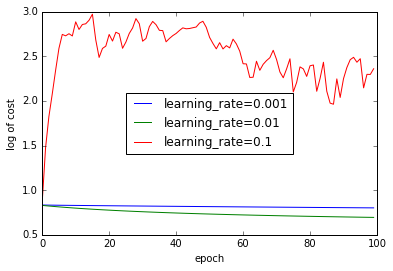

In [10]:
# Visualize results
epochs = np.arange(len(costs_0))
plt.plot(epochs, np.log(costs_0), label='learning_rate=0.001') # Use log cost to see clearer
plt.plot(epochs, np.log(costs_1), label='learning_rate=0.01')
plt.plot(epochs, np.log(costs_2), label='learning_rate=0.1')
plt.xlabel('epoch')
plt.ylabel('log of cost')
plt.legend(loc='best')

Bình luận về đồ thị kết quả: TODO
- Với learning_rate là 0.1, dễ thấy đường biểu diễn chi phí theo số lần huấn luyện (epoch) là các đoạn gấp khúc, hỗn loạn, nhảy vọt từ chi phí 1.0 lên > 2.5 chỉ sau vài epoch và sau đó lên xuống thất thường với epoch tăng dần. Nhưng nhìn chung, chi phí luôn dao động > 2.0, đôi lúc chạm đến 3.0. Do đó, learning_rate này không khả quan.
- Với learning_rate là 0.001 và 0.01, đường chi phí giảm dần theo số lần huấn luyện (epoch), mức độ giảm cũng giảm dần theo độ tăng epoch. Tuy nhiên, nhìn chung, 2 learning_rate này cho kết quả khả quan với chi phí thấp (cost < 1.0). Trong đó, learning_rate = 0.01 cho kết quả tốt hơn cả.
- Tóm lại, learning_rate = 0.01 cho kết quả tốt nhất. Điều đó cho thấy, giá trị khả quan của learning_rate nằm ở một đoạn nhất định, không phải là quá lớn hay quá nhỏ.

**3.** Chọn `W_1` ứng với `learning_rate` tốt nhất ở trên là bộ tham số của hàm dự đoán cuối cùng; đánh giá hàm dự đoán này bằng cách tính độ lỗi trên tập kiểm tra (ngoài ra, bạn cũng cho in ra độ lỗi trên tập huấn luyện)

In [11]:
# TODO
training_err = errs_1[-1]
test_out = compute_softmax_output(W_1, test_X)
test_err = sum([int(np.argmax(y_out)) != y[0] for y_out, y in zip(test_out, test_Y)]) * 100.0 / len(test_Y)

print 'Training error: %.3f%%' % (training_err)
print 'Test error: %.3f%%' % (test_err)

Training error: 67.357%
Test error: 67.760%


Kết quả chạy của mình: `Training err 67.357%, test err 67.760%`